In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
import scipy.stats as stats
from findpeaks import findpeaks
from electrodes_manipulation import Eletrode

In [12]:
elec = Eletrode()

In [13]:
comertial_electrode = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\data\\comercial.csv', sep=';')
comertial_rodamine = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\Workspace\\heart_attack_analysis\\data\\comercial_rodamina.csv', sep=';')
polimid = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\Workspace\\heart_attack_analysis\\data\\Polimida.csv', sep=';')
polimid_rodamine = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\data\\polimida_rodamina.csv', sep=';')

In [14]:
comertial_electrode.head()

,V,A1,A2,A3
0,"0,649998","59,9268","56,3561","56,2829"
1,"0,648002","59,5514","55,9991","55,935"
2,"0,646005","59,1852","55,6695","55,6054"
3,"0,644009","58,8464","55,3491","55,285"
4,"0,642012","58,4985","55,0378","54,9737"


In [15]:
comertial_rodamine.head()

,V,Ac1 ac+R6G VC,Ac2 ac+R6G VC,Ac3 ac+R6G VC,Ac4 ac+R6G VC
0,"0,649998","59,1577","60,1831","59,6979","61,236"
1,"0,648002","57,8759","58,9563","58,352","59,9268"
2,"0,646005","57,2625","58,3429","57,7111","59,2859"
3,"0,644009","56,7773","57,8485","57,2168","58,7823"
4,"0,642012","56,3287","57,3999","56,759","58,3062"


In [16]:
polimid.head()

,V,B5 13071,C2 13071,D6 13071,E3 13071
0,"0,550022","49,0867","48,986","51,9066","48,51"
1,"0,548026","45,6168","45,388","48,4001","44,7837"
2,"0,546029","44,2252","43,9048","46,862","43,2639"
3,"0,544033","43,3555","43,035","45,9464","42,3667"
4,"0,542036","42,6871","42,3575","45,2689","41,6983"


In [17]:
polimid_rodamine.head()

,V,A4 ac+rod becker 30s,C3 ac+rod becker 30s,D2 ac+rod becker 30s,E5 ac+rod becker 30s
0,"0,550022","42,6413","44,4907","43,3371","43,6301"
1,"0,548026","41,7258","43,447","42,1836","42,7695"
2,"0,546029","41,2589","42,9252","41,6983","42,211"
3,"0,544033","40,8194","42,5132","41,2039","41,7624"
4,"0,542036","40,5447","42,1286","40,7828","41,4328"


In [18]:
comertial_electrode = elec.convert_df_to_float_df(comertial_electrode)
comertial_rodamine = elec.convert_df_to_float_df(comertial_rodamine)
polimid = elec.convert_df_to_float_df(polimid)
polimid_rodamine = elec.convert_df_to_float_df(polimid_rodamine)

In [19]:
print(comertial_electrode.isna().any().sum())
print(comertial_rodamine.isna().any().sum())
print(polimid.isna().any().sum())
print(polimid_rodamine.isna().any().sum())

0
0
0
0


In [45]:
# Função que retorma o vetor do tempo dado o potencial
def getTime( scan_rate, potential ):
    time = np.zeros(shape=potential.shape)
    delta_t = abs(potential[1] - potential[0]) / scan_rate
    
    for i in range(1, len(potential)):
        time[i] = delta_t + time[i - 1]
    
    return time
    
# Função que retorna o tempo total da série de voltametria
def get_total_time( scan_rate, potential):
    time = getTime(scan_rate, potential)
    return time[len(time)-1] 
    
# Função de Filtragem do sinal
def filter_low_pass_butterworth( fs, fc, order, y):
    # Frequência de corte normalizada
    w = fc / (fs / 2)
    print(f"Critical frequency {w}")
    b, a = signal.butter(order, w, 'low')
    out = signal.lfilter(b, a, y)
    #print(f'Shape Saida: {len(out)}')
    return out
    
# Função que calcula o sample rate do processo
def get_sampleRate( totalTime, lenght):
    return lenght / totalTime
    

    
# Função que calcula a primeira derivada
def derivate(x_axis, y_axis, time = False):
    
        #print(f'X Shape {len(x_axis)}')
        #print(f'Y Shape {len(y_axis)}')
    sample_rate = 0
    h = abs(x_axis[1] - x_axis[0])          # Calculating h difference
    # Padding to not losing data between derivate
    y = np.zeros(shape = (len(y_axis) + 2))
    # Coping the y array into y
    y[1:-1] = y_axis
    # Duplicating the last and the first elements
    y[0] = y_axis[0]
    y[len(y) - 1] = y_axis[len(y_axis) - 1]
    
    for k in range(len(y) - 1):
        y[k] = (y[k + 1] - y[k])/h
    
    # Filtragem do sinal da derivada
    if (not(time)):
        total_time = get_total_time(0.75, x_axis)
        sample_rate = get_sampleRate(total_time, len(x_axis))
    else:
        sample_rate = 1 / h
        
    out = filter_low_pass_butterworth(sample_rate, 5, 10, y[1:-1])
    #print(len(out))
    return (y[1:-1], out)

# Pega os argomentos das correntes anódicas e catódicas, retorna -1 se não achar o pico
def getAnodicAndCathodicArguments(current, fp, ox_inf = 500, ox_sup = 630, red_inf = 200, red_sup = 300):
    result_an_arg = 0
    result_cat_arg = 0
    # Encontrando os picos das duas funções
    results = fp.fit(current)
    #fp.plot(figsize=(12,7))
    results_df = results['df']
    # Separando os picos relacionados à oxidação
    results_oxidation = results_df.iloc[ox_inf:ox_sup,:]
    results_reduction = results_df.iloc[red_inf:red_sup, :]
    arg_anodic = results_oxidation[results_oxidation['peak'] == True]['x'].values
    arg_cathodic = results_reduction[results_reduction['valley'] == True]['x'].values
    
    if (len(arg_anodic) == 0):
        print("Erro na corrente anódica")
        result_an_arg = -1
    else:
        result_an_arg = arg_anodic[0]
        
    if (len(arg_cathodic) == 0):
        print("Erro na corrente catódica")
        result_cat_arg = -1
    else:
        result_cat_arg = arg_cathodic[0]
        
    return (result_an_arg, result_cat_arg)

In [38]:
def getFeaturesList(dataframe):
    elec_current_derivate = pd.DataFrame(columns=dataframe.columns)
    elec_anodic_current_rod = []
    elec_cathodic_current_rod = []
    elec_diff_ano_cat_potential_rod = []
    elec_diff_ano_cat_current_rod = []
    elec_potential = dataframe.loc[:, dataframe.columns[0]].values

    fp = findpeaks(method='peakdetect', lookahead=10)

    plot_peak = True

    for i in range (1, dataframe.shape[1]):
    
        current = dataframe.iloc[:, i].values
        current_derivate, derived_current_filtered = derivate(elec_potential, current)
        elec_current_derivate[comertial_rodamine.columns[i]] = derived_current_filtered
        (anodic, cathodic) = getAnodicAndCathodicArguments(current, fp)
    
    
        if (anodic != -1 and cathodic != -1):
            elec_anodic_current_rod.append(current[anodic])
            elec_cathodic_current_rod.append(current[cathodic])
            elec_diff_ano_cat_current_rod.append(abs(current[anodic] - current[cathodic]))
            elec_diff_ano_cat_potential_rod.append(abs(elec_potential[anodic] - elec_potential[cathodic]))
            plot_peak = True
        
        elif (anodic == -1):
            elec_anodic_current_rod.append(np.nan)
            elec_cathodic_current_rod.append(np.nan)
            elec_diff_ano_cat_current_rod.append(np.nan)
            elec_diff_ano_cat_potential_rod.append(current[cathodic])
         
        elif (cathodic == -1):
            elec_anodic_current_rod.append(current[anodic])
            elec_cathodic_current_rod.append(np.nan)
            elec_diff_ano_cat_current_rod.append(np.nan)
            elec_diff_ano_cat_potential_rod.append(np.nan)

 
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
        ax1.set_title("Cyclic Vontametry NEGATIVE Patient: " + dataframe.columns[i])
        ax1.set_ylabel("Current uA")
        ax1.set_xlabel("Potential V")
        ax1.grid(True)
        
        ax2.set_title("Derivate Voltametry NEGATIVE Patient: " + dataframe.columns[i])
        ax2.set_ylabel("delta_Current uA/V")
        ax2.set_xlabel("Potential V")
        
        ax2.grid(True)
        
        ax3.set_title("Derivate Voltametry NEGATIVE Patient: " + dataframe.columns[i])
        ax3.set_ylabel("delta_Current uA/V")
        ax3.set_xlabel("Time")
        
        ax3.grid(True)
        
          
        ax1.plot(elec_potential, current, color='b', label="case: " + str(i + 1))

        if (plot_peak):
            ax1.plot(elec_potential[anodic], current[anodic], marker="x", markersize=10, markeredgecolor="black")
            ax1.plot(elec_potential[cathodic], current[cathodic], marker="x", markersize=10, markeredgecolor="black")
        
        ax1.legend() 
        ax2.plot(elec_potential, current_derivate, color='b', label="case: " + str(i + 1))
        ax2.legend()
        #ax3.plot(potential_neg, derived_current_filtered, color=colors[plots], label="case: " + str(plots + 1))
        ax3.plot(derived_current_filtered, color='b', label="case: " + str(i + 1))
        ax3.legend() 
        plot_peak = False
    
    plt.show()

    return (elec_current_derivate, elec_anodic_current_rod, elec_cathodic_current_rod, elec_diff_ano_cat_potential_rod, elec_diff_ano_cat_current_rod)

Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


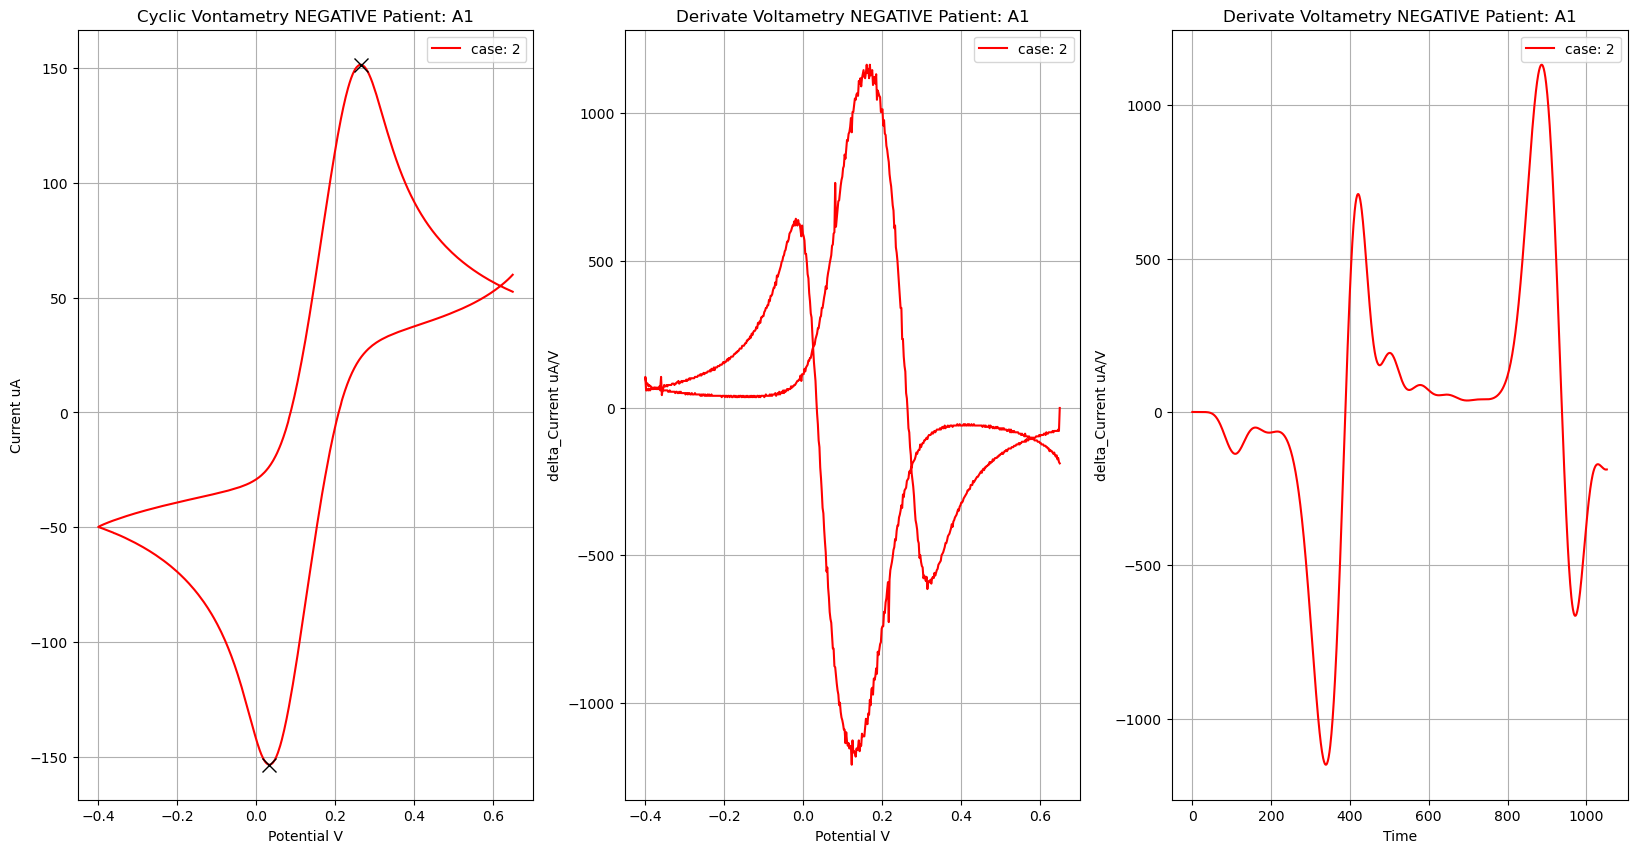

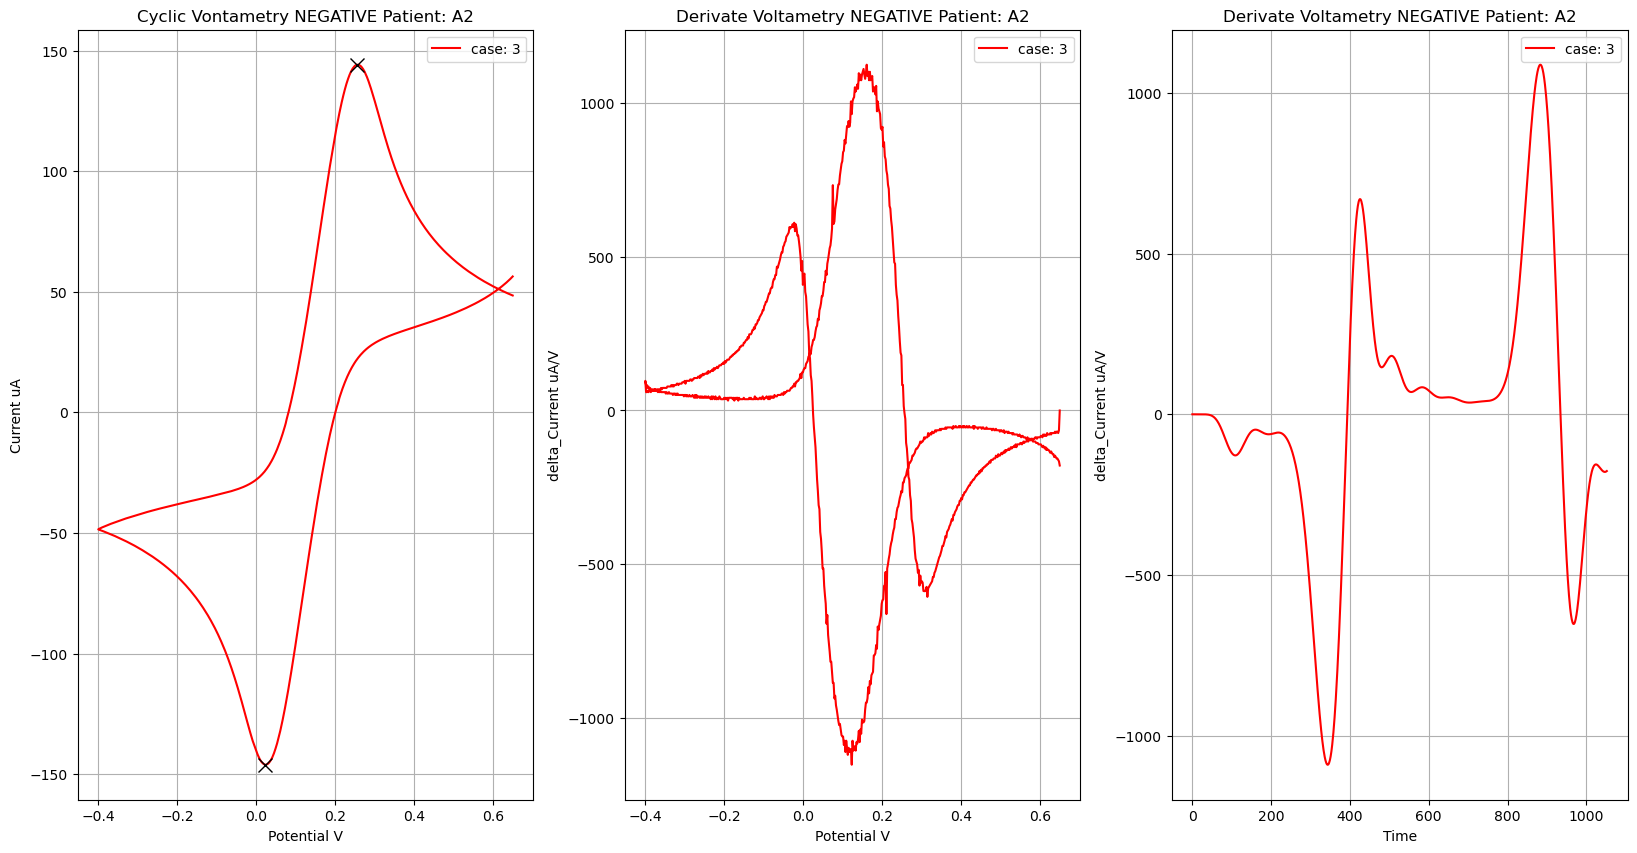

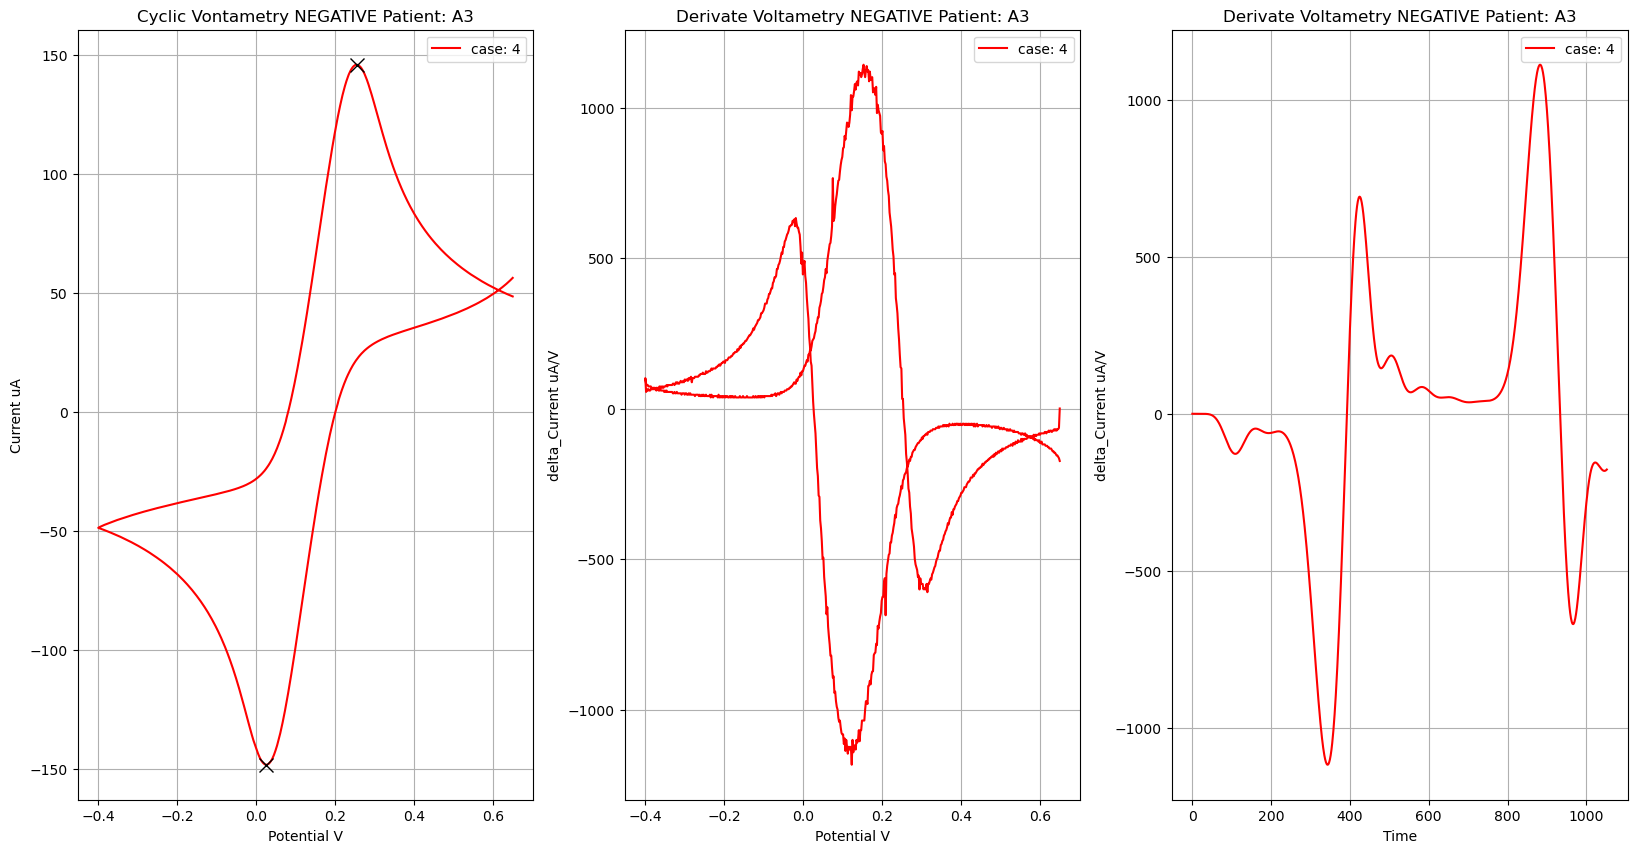

In [35]:
comertial_elec_derivate = pd.DataFrame(columns=comertial_electrode.columns)
comertial_elec_anodic_current = []
comertial_elec_cathodic_current = []
comertial_elec_diff_ano_cat_potential = []
comertial_elec_diff_ano_cat_current = []
potential_comertial_elec = comertial_electrode.loc[:, comertial_electrode.columns[0]].values

fp = findpeaks(method='peakdetect', lookahead=10)

plot_peak = True

for i in range (1, comertial_electrode.shape[1]):
    
    current = comertial_electrode.iloc[:, i].values
    current_derivate, derived_current_filtered = derivate(potential_comertial_elec, current)
    comertial_elec_derivate[comertial_electrode.columns[i]] = derived_current_filtered
    (anodic, cathodic) = getAnodicAndCathodicArguments(current, fp)
    
    
    if (anodic != -1 and cathodic != -1):
        comertial_elec_anodic_current.append(current[anodic])
        comertial_elec_cathodic_current.append(current[cathodic])
        comertial_elec_diff_ano_cat_current.append(abs(current[anodic] - current[cathodic]))
        comertial_elec_diff_ano_cat_potential.append(abs(potential_comertial_elec[anodic] - potential_comertial_elec[cathodic]))
        plot_peak = True
        
    elif (anodic == -1):
         comertial_elec_anodic_current.append(np.nan)
         comertial_elec_cathodic_current.append(np.nan)
         comertial_elec_diff_ano_cat_current.append(np.nan)
         comertial_elec_diff_ano_cat_potential.append(current[cathodic])
         
    elif (cathodic == -1):
        comertial_elec_anodic_current.append(current[anodic])
        comertial_elec_cathodic_current.append(np.nan)
        comertial_elec_diff_ano_cat_current.append(np.nan)
        comertial_elec_diff_ano_cat_potential.append(np.nan)

 
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
    ax1.set_title("Cyclic Vontametry NEGATIVE Patient: " + comertial_electrode.columns[i])
    ax1.set_ylabel("Current uA")
    ax1.set_xlabel("Potential V")
    ax1.grid(True)
        
    ax2.set_title("Derivate Voltametry NEGATIVE Patient: " + comertial_electrode.columns[i])
    ax2.set_ylabel("delta_Current uA/V")
    ax2.set_xlabel("Potential V")
        
    ax2.grid(True)
        
    ax3.set_title("Derivate Voltametry NEGATIVE Patient: " + comertial_electrode.columns[i])
    ax3.set_ylabel("delta_Current uA/V")
    ax3.set_xlabel("Time")
        
    ax3.grid(True)
        
          
    ax1.plot(potential_comertial_elec, current, color='r', label="case: " + str(i + 1))

    if (plot_peak):
        ax1.plot(potential_comertial_elec[anodic], current[anodic], marker="x", markersize=10, markeredgecolor="black")
        ax1.plot(potential_comertial_elec[cathodic], current[cathodic], marker="x", markersize=10, markeredgecolor="black")
        
    ax1.legend() 
    ax2.plot(potential_comertial_elec, current_derivate, color='r', label="case: " + str(i + 1))
    ax2.legend()
    #ax3.plot(potential_neg, derived_current_filtered, color=colors[plots], label="case: " + str(plots + 1))
    ax3.plot(derived_current_filtered, color='r', label="case: " + str(i + 1))
    ax3.legend() 
    plot_peak = False
    
plt.show()

Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


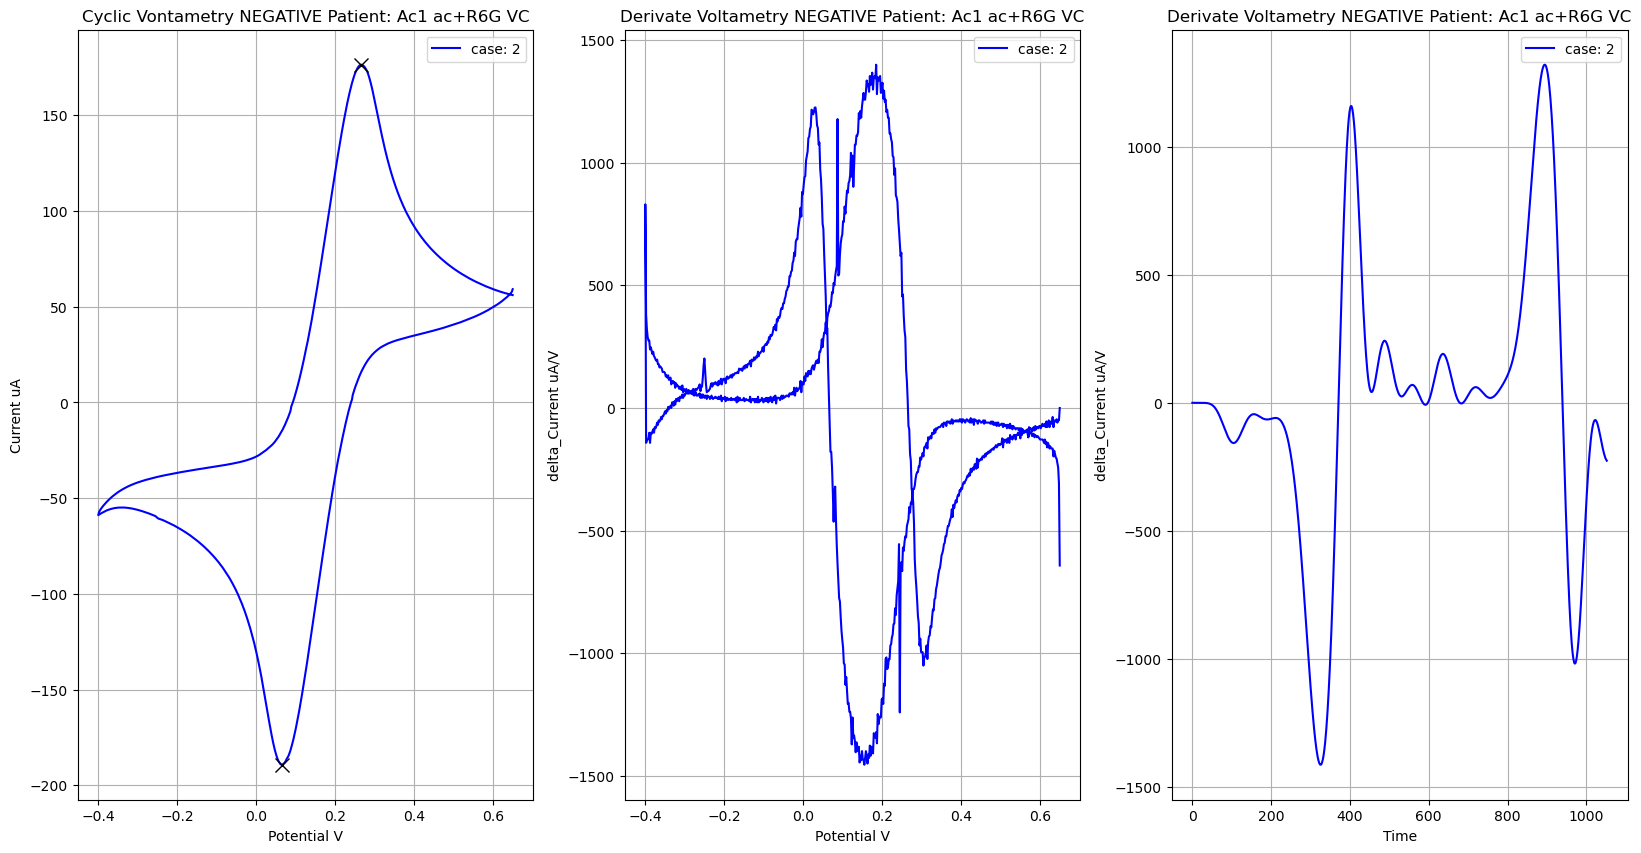

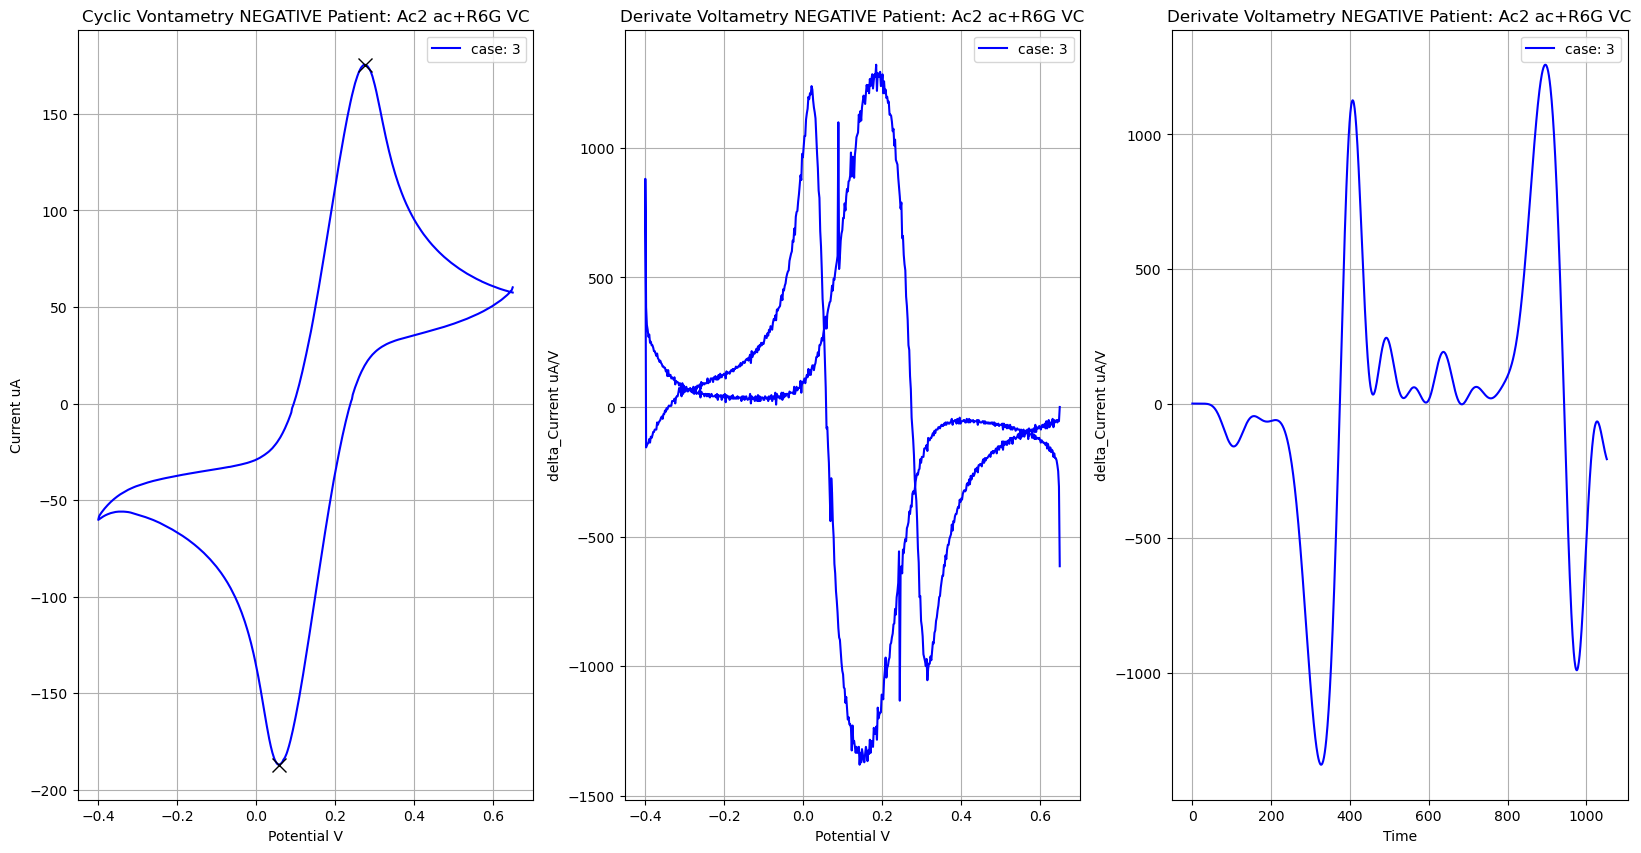

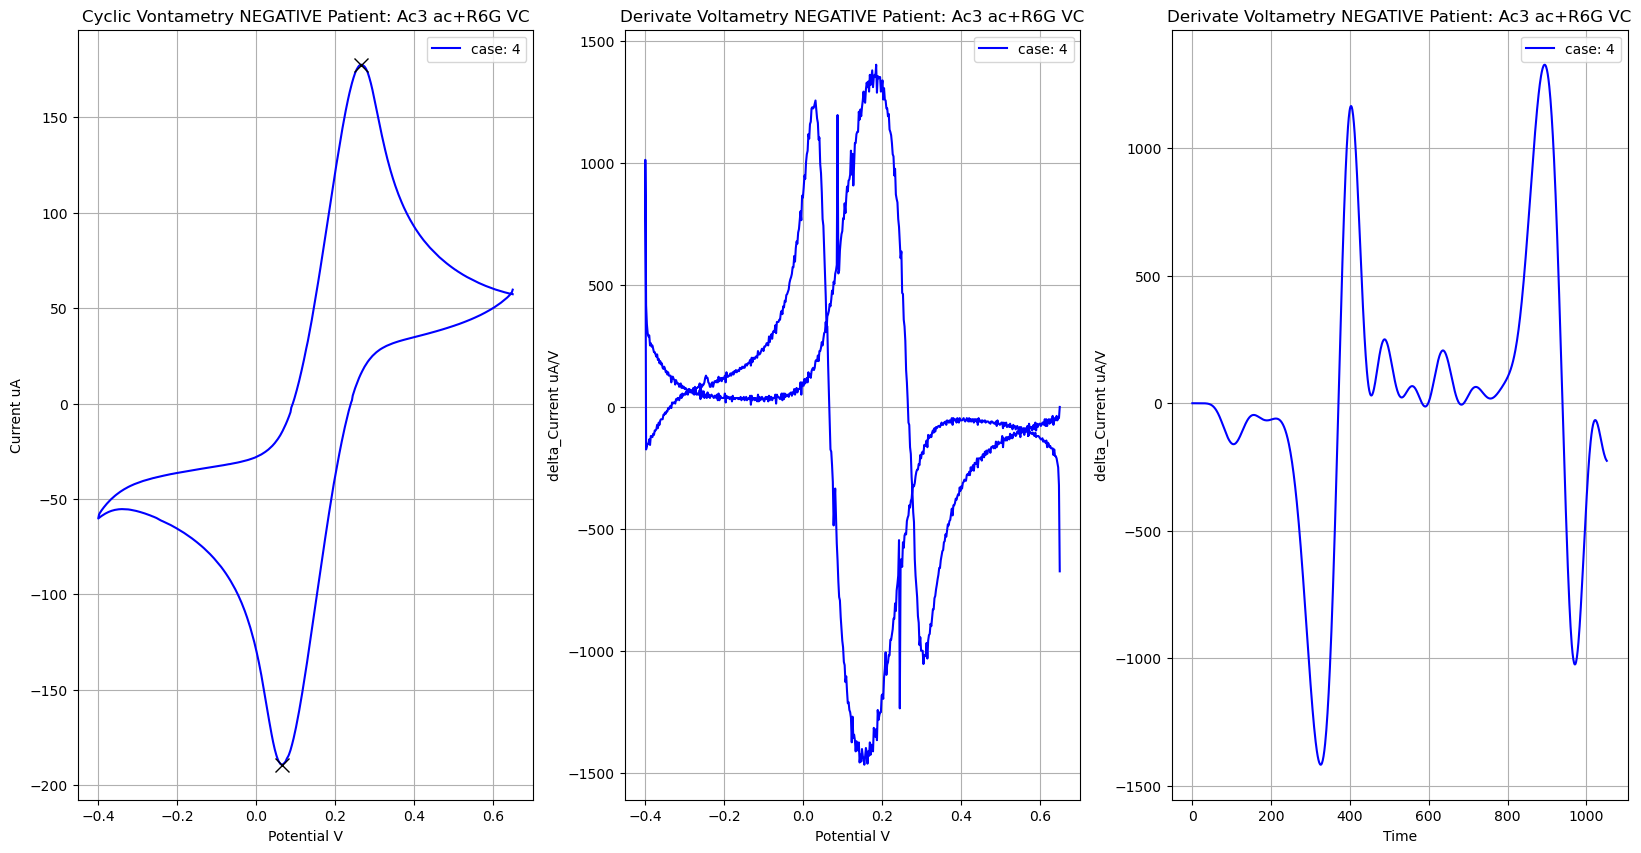

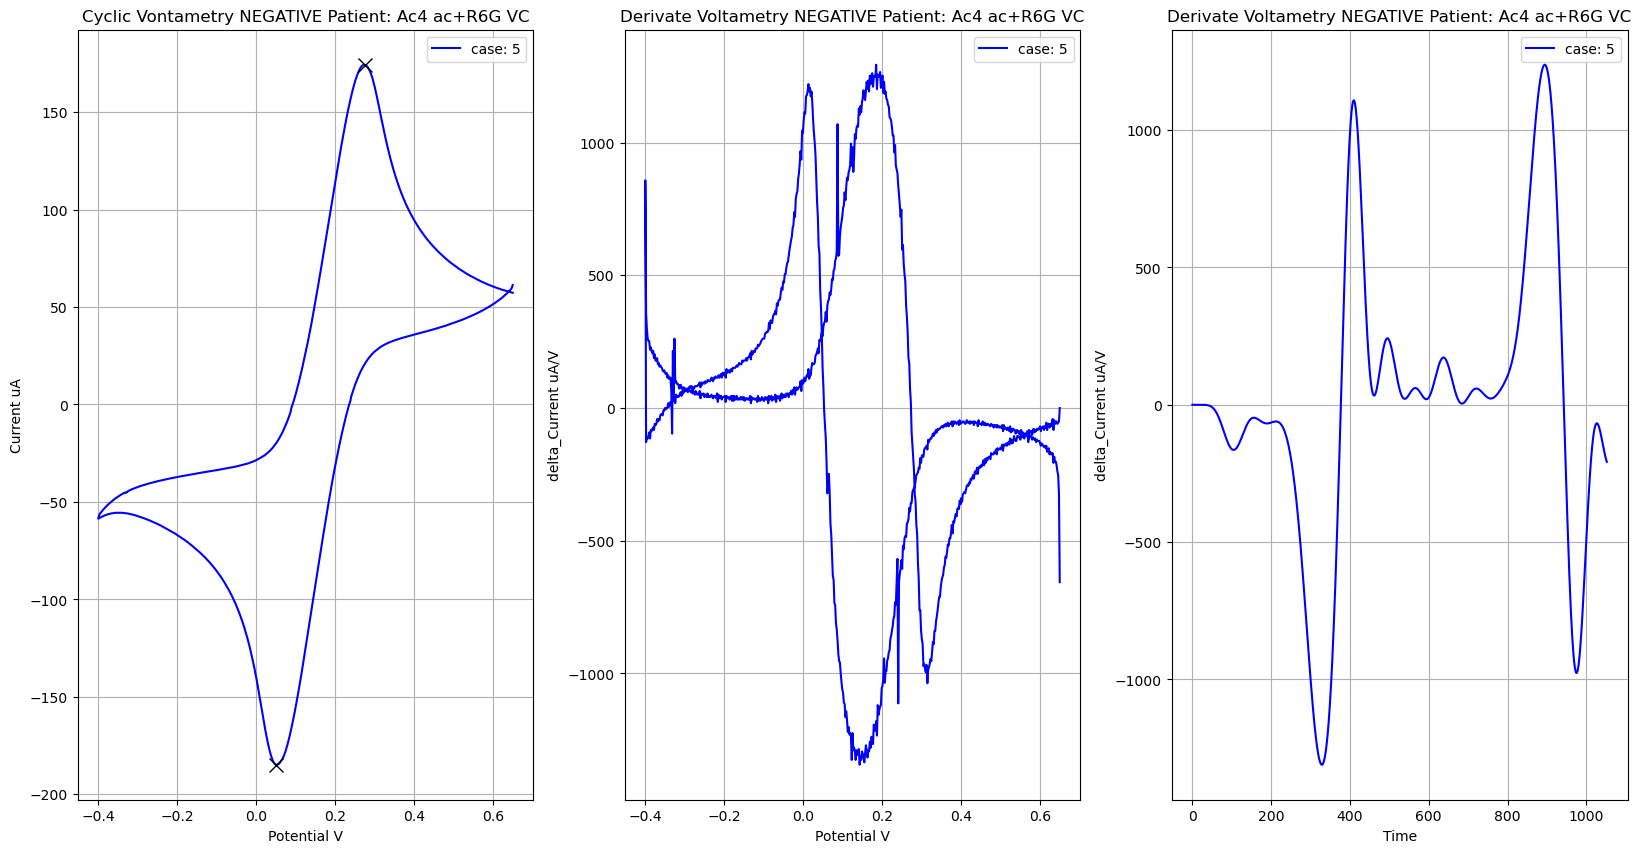

In [36]:
comertial_elec_derivate_rod = pd.DataFrame(columns=comertial_rodamine.columns)
comertial_elec_anodic_current_rod = []
comertial_elec_cathodic_current_rod = []
comertial_elec_diff_ano_cat_potential_rod = []
comertial_elec_diff_ano_cat_current_rod = []
potential_comertial_elec_rod = comertial_rodamine.loc[:, comertial_rodamine.columns[0]].values

fp = findpeaks(method='peakdetect', lookahead=10)

plot_peak = True

for i in range (1, comertial_rodamine.shape[1]):
    
    current = comertial_rodamine.iloc[:, i].values
    current_derivate, derived_current_filtered = derivate(potential_comertial_elec, current)
    comertial_elec_derivate_rod[comertial_rodamine.columns[i]] = derived_current_filtered
    (anodic, cathodic) = getAnodicAndCathodicArguments(current, fp)
    
    
    if (anodic != -1 and cathodic != -1):
        comertial_elec_anodic_current_rod.append(current[anodic])
        comertial_elec_cathodic_current_rod.append(current[cathodic])
        comertial_elec_diff_ano_cat_current_rod.append(abs(current[anodic] - current[cathodic]))
        comertial_elec_diff_ano_cat_potential_rod.append(abs(potential_comertial_elec[anodic] - potential_comertial_elec[cathodic]))
        plot_peak = True
        
    elif (anodic == -1):
         comertial_elec_anodic_current_rod.append(np.nan)
         comertial_elec_cathodic_current_rod.append(np.nan)
         comertial_elec_diff_ano_cat_current_rod.append(np.nan)
         comertial_elec_diff_ano_cat_potential_rod.append(current[cathodic])
         
    elif (cathodic == -1):
        comertial_elec_anodic_current_rod.append(current[anodic])
        comertial_elec_cathodic_current_rod.append(np.nan)
        comertial_elec_diff_ano_cat_current_rod.append(np.nan)
        comertial_elec_diff_ano_cat_potential_rod.append(np.nan)

 
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
    ax1.set_title("Cyclic Vontametry NEGATIVE Patient: " + comertial_rodamine.columns[i])
    ax1.set_ylabel("Current uA")
    ax1.set_xlabel("Potential V")
    ax1.grid(True)
        
    ax2.set_title("Derivate Voltametry NEGATIVE Patient: " + comertial_rodamine.columns[i])
    ax2.set_ylabel("delta_Current uA/V")
    ax2.set_xlabel("Potential V")
        
    ax2.grid(True)
        
    ax3.set_title("Derivate Voltametry NEGATIVE Patient: " + comertial_rodamine.columns[i])
    ax3.set_ylabel("delta_Current uA/V")
    ax3.set_xlabel("Time")
        
    ax3.grid(True)
        
          
    ax1.plot(potential_comertial_elec, current, color='b', label="case: " + str(i + 1))

    if (plot_peak):
        ax1.plot(potential_comertial_elec[anodic], current[anodic], marker="x", markersize=10, markeredgecolor="black")
        ax1.plot(potential_comertial_elec[cathodic], current[cathodic], marker="x", markersize=10, markeredgecolor="black")
        
    ax1.legend() 
    ax2.plot(potential_comertial_elec, current_derivate, color='b', label="case: " + str(i + 1))
    ax2.legend()
    #ax3.plot(potential_neg, derived_current_filtered, color=colors[plots], label="case: " + str(plots + 1))
    ax3.plot(derived_current_filtered, color='b', label="case: " + str(i + 1))
    ax3.legend() 
    plot_peak = False
    
plt.show()

Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


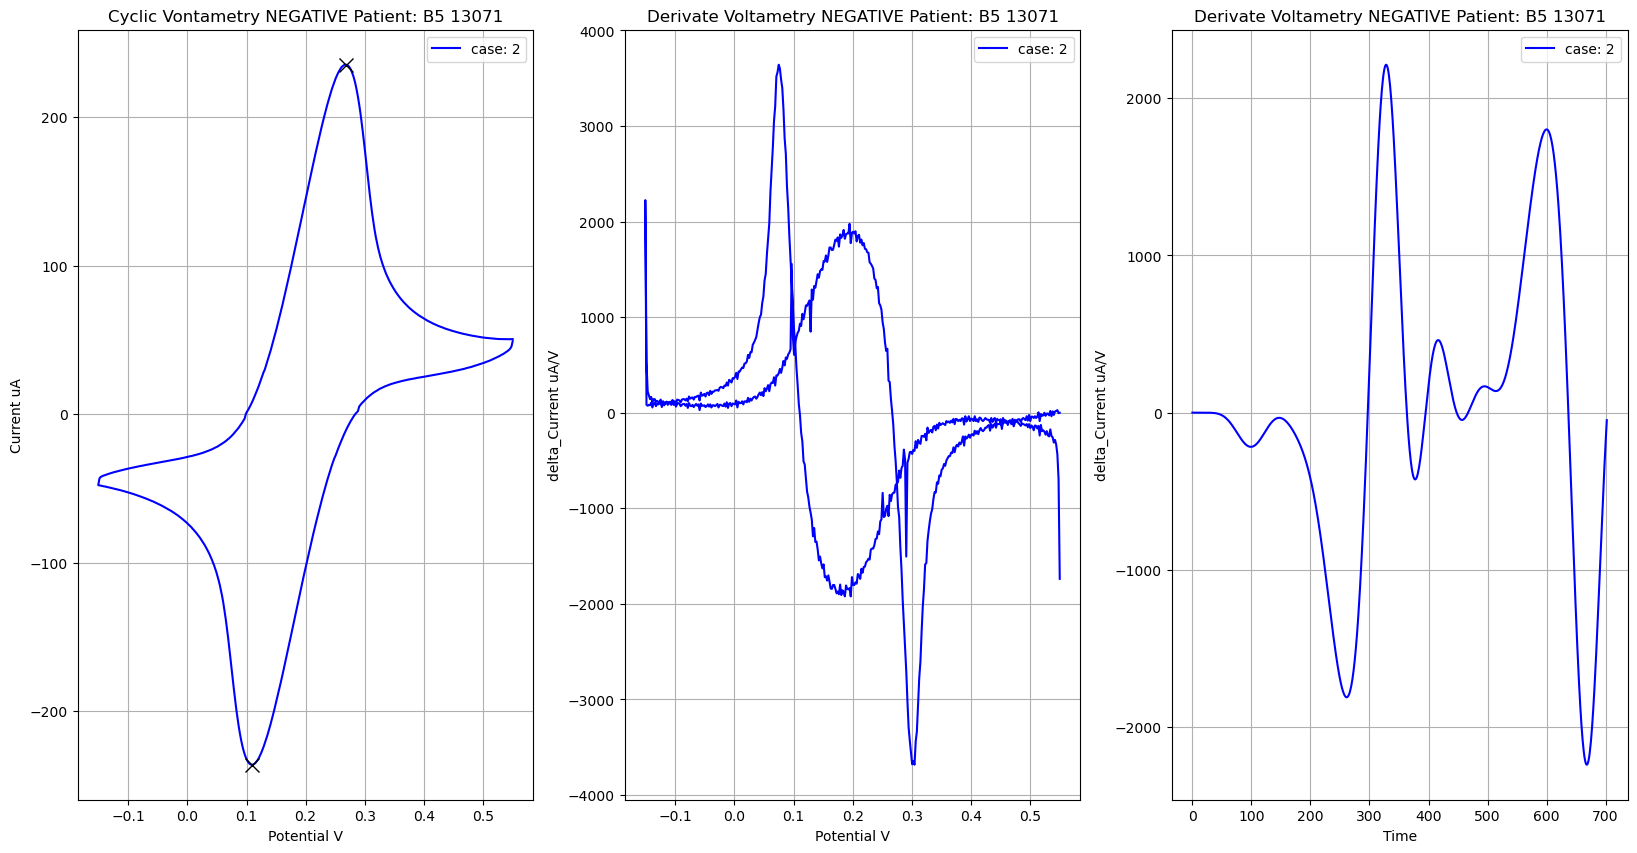

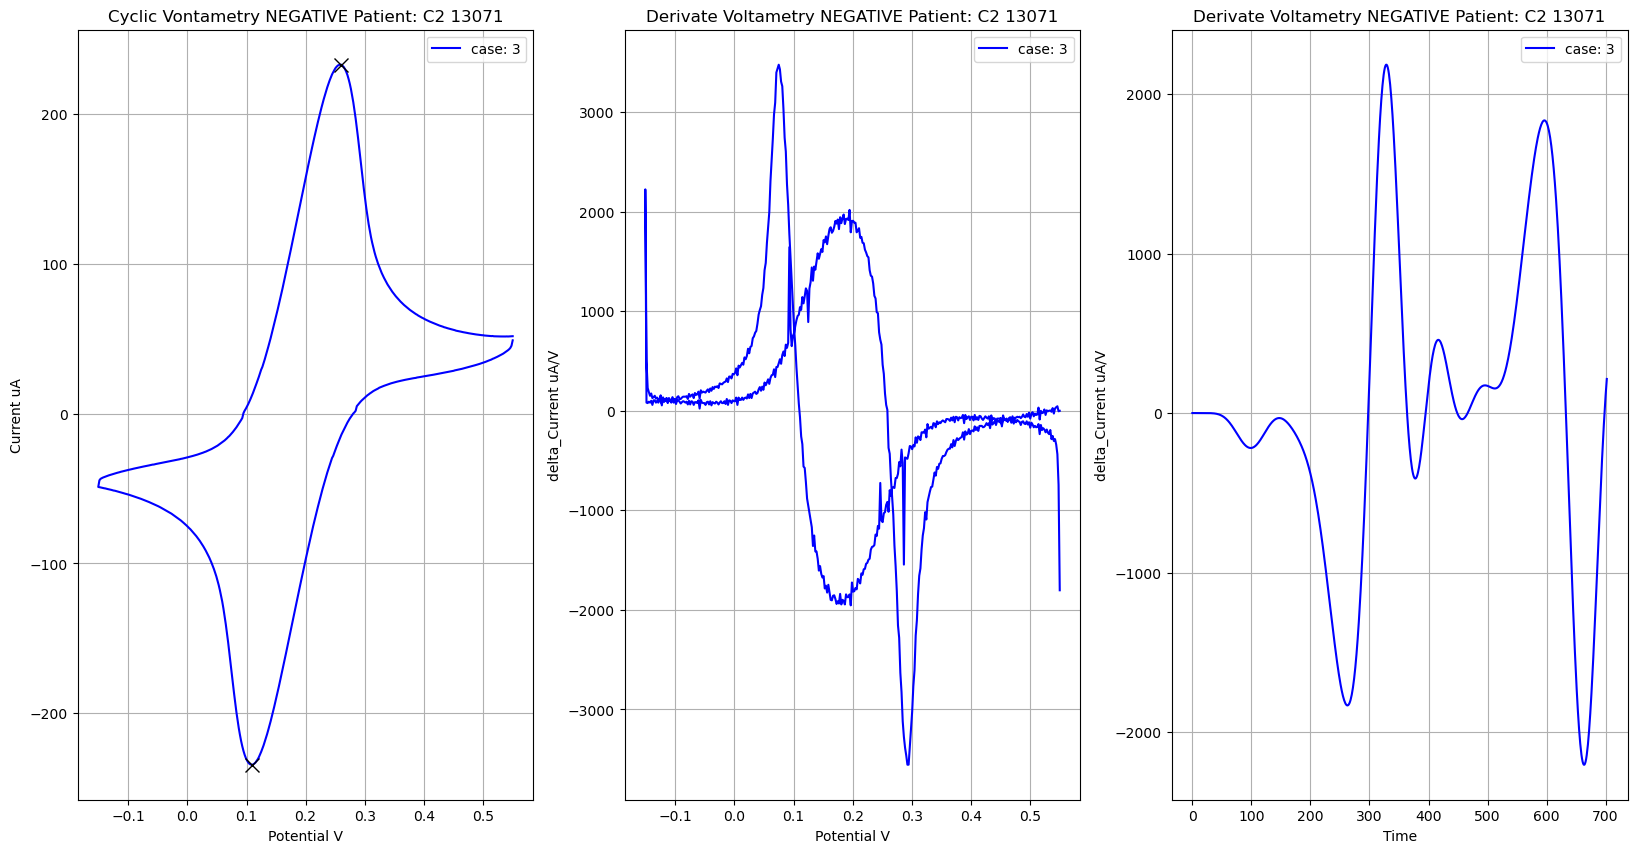

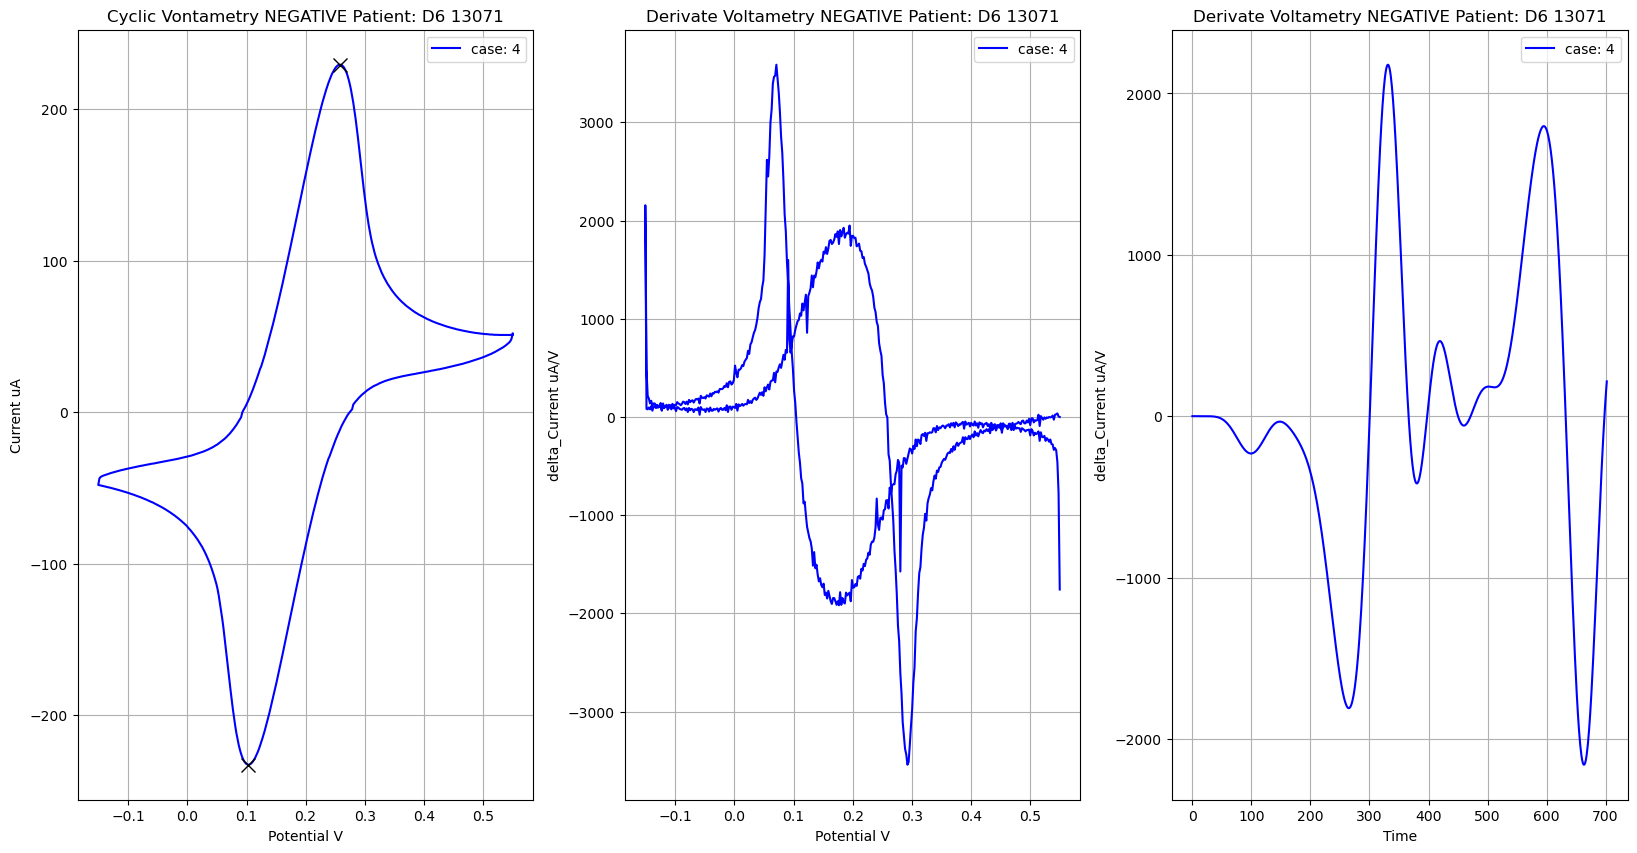

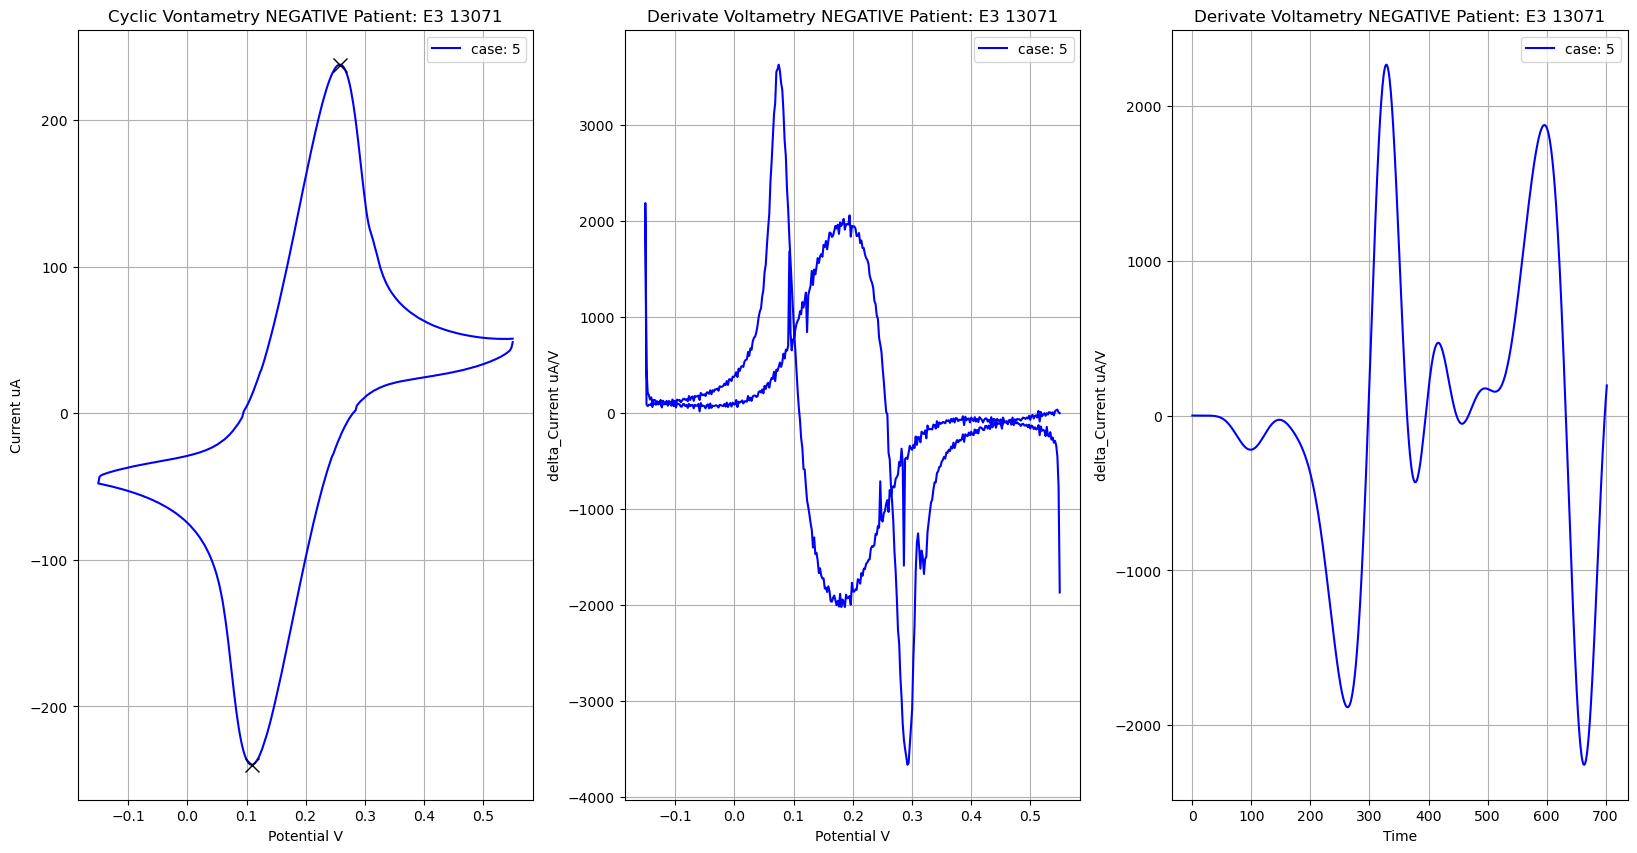

In [46]:
poli_elec_current_derivate, poli_elec_anodic_current, poli_elec_cathodic_current, poli_elec_diff_ano_cat_potential, poli_elec_diff_ano_cat_current = getFeaturesList(polimid)

In [ ]:
poli_elec_current_derivate_rod, poli_elec_anodic_current_rod, poli_elec_cathodic_current_rod, poli_elec_diff_ano_cat_potential_rod, poli_elec_diff_ano_cat_current_rod = getFeaturesList(polimid)